In this notebook, we use supervised learning to train a network with one hidden layer to move to a target in continuous space. First, the agent is trained to go to target 1, then to go to target 2, and so on, with more training on target 1 than on the other targets. Then the agent is tested on each target, with the result that performance is better for targets that were more recently learned.

By introducing a second pathway with slow Hebbian weights, the network remembers how to get to target 1 better than it otherwise would, due to the extra reinforcement via the second pathway.

This code may be reused or adapted, in which case please cite the following paper:

"Remembrance of things practiced: Fast and slow learning in cortical and subcortical circuits," James M. Murray and G. Sean Escola (Nature Communications, 2020).

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def theta(xx):
    return 0.5*(1 + np.sign(xx))

def rectify(xx):
    return 0.5*(1 + np.sign(xx))*xx

def phi(xx):
    return np.tanh(xx)

def dphi(xx):
    return 1/np.cosh(xx)**2

def smooth(xx, window=5):
    '''Smooth a 1D array with a window of given size (which should be odd).'''
    xx_smooth = np.copy(xx)
    for ii in range(int(window/2-0.5), len(xx)-int(window/2-0.5)):
        xx_smooth[ii] = np.mean(xx[ii-int(window/2-0.5):ii+int(window/2-0.5)+1])

    return xx_smooth


<IPython.core.display.Javascript object>


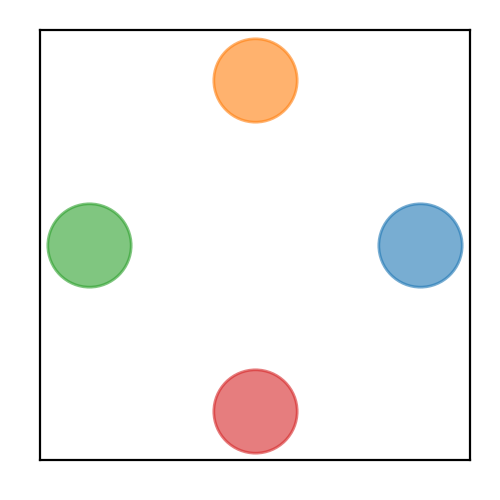

In [297]:
# Plot the target locations.

plt.figure(figsize=(2.5,2.5))
for th in np.arange(0, 2*np.pi, 2*np.pi/4):
    plt.plot([np.cos(th)], [np.sin(th)], 'o', ms=30, alpha=0.6)
plt.xlim(-1.3, 1.3)
plt.ylim(-1.3, 1.3)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('figs/targets.pdf')

In [3]:
class Agent:
    '''
    This class defines an agent and methods to train it with supervised learning. 
    The goal is, given a context input, to navigate to the correct target location.

    Inputs
    ------
    n : n = (nm, nh, nz, ng) is a tuple giving the numbers of units in the input 
        (m=MC and h=Thal), hidden (z=Striatum), and readout (r=GPi) layers.
    
    learning_rates : learning rates used for corticostriatal and thalamostriatal updates.
    
    n_targets : number of targets for reaching, distributed evenly around the unit circle.
    
    sigma : amplitude of noise.
    '''

    def __init__(self, n=(50, 50, 10), learning_rates=(1e-3, 0), n_targets=8, sigma=0):
        
        # Learning rates:
        self.eta_w = learning_rates[0]
        self.eta_v = learning_rates[1]
        self.n_targets = n_targets

        self.t_max = 10  # duration of each episode
        self.sigma = sigma  # amplitude of noise

        self.nm = n[0]  # number of units in motor cortex (random state representation)
        self.nh = n[1]  # number of units in thalamus (random state representation)
        self.nz = n[2]  # number of units in striatum 
        self.ng = 2  # number of readout units (one for each velocity component)

        # Specify the initial and terminal states:
        self.s_initial = np.array([0., 0.])
        #self.s_terminal = np.array([[1,0], [0,1], [-1,0], [0,-1]], dtype=float)
        th = np.arange(0, 2*np.pi, 2*np.pi/self.n_targets)
        self.s_terminal = np.array([np.cos(th), np.sin(th)]).T

        # Fixed random weights projecting state and context to m and h:
        self.wc_m = np.random.randn(len(self.s_terminal), self.nm)
        self.wc_h = np.random.randn(len(self.s_terminal), self.nh)

        # Fixed random weights projecting state (location) to m and h:
        self.ws_m = np.random.randn(self.nm, 2)
        self.ws_h = np.random.randn(self.nh, 2)

        # Network weights:
        self.w = np.random.randn(self.nz, self.nm)/self.nm**0.5
        self.v = np.random.randn(self.nz, self.nh)/self.nh**0.5
        self.u = np.random.randn(self.ng, self.nz)/self.nz**0.5

        self.verbose = 0    # If 2, print state and action at each step;
                            # if 1, print n_steps after each episode;
                            # if 0, print nothing.
                        
        # For computing the alignment of inputs to DLS:
        self.alignment = []

        self.rbar = 0  # running average of reward


    def run_trial(self, target, plot_traj=False):
        '''
        Starting from a given initial state, run the agent until it either
        reaches the target state or times out, then update weights.
        
        Parameters
        ----------
        target : Integer specifying which target location to go to.

        Returns the number of timesteps before reward is reached and the reward.
        '''
        
        loss = np.zeros(self.t_max)
        dv, dw, du = 0, 0, 0
        s = np.array([0., 0.])  # initialize state
        states = np.zeros((1,2))
        states[0,:] = s
        v_ = np.outer((30*(np.arange(self.t_max)/self.t_max)**2
                       - 60*(np.arange(self.t_max)/self.t_max)**3
                       + 30*(np.arange(self.t_max)/self.t_max)**4)/self.t_max,
                      self.s_terminal[target,:] - s)
        for tt in range(self.t_max):
            xi = self.sigma*np.random.randn(self.ng)
            x = self.wc_m[target, :] + np.dot(self.ws_m, s)
            y = self.wc_h[target, :] + np.dot(self.ws_h, s)
            m = np.dot(self.w, x)
            h = np.dot(self.v, y)
            z = phi(m + h)
            g = np.dot(self.u, z) + xi
            err = v_[tt,:] - g
            loss[tt] = 0.5*np.linalg.norm(err)**2
            s += g
                        
            states = np.append(states, [s], axis=0)
                        
            # Weight updates:
            dv += self.eta_v*(-self.v + np.outer(z, y))
            du += self.eta_w*np.outer(err, z)
            dw += self.eta_w*np.outer(np.dot(self.u.T, err)*dphi(m+h), x)
            
            if self.verbose==2:
                print('Target: ', self.s_terminal[target], '\t Step: ', tt, 
                      '\t State: ', s, '\t Reward: ', r)
          
            tt += 1
           
        # Update the weights:
        self.u = self.u + du
        self.w = self.w + dw
        self.v = self.v + dv

        if plot_traj:
            plt.figure(figsize=(2,2))
            plt.xlim(-1.2, 1.2)
            plt.ylim(-1.2, 1.2)
            plt.xticks([])
            plt.yticks([])
            plt.plot(self.s_terminal[target][0], self.s_terminal[target][1], 'or', ms=10)
            plt.plot(np.array(states)[:,0], np.array(states)[:,1], '.')
            plt.tight_layout()
            plt.show()
            
        return np.mean(loss)


    def run_session(self, n_episodes, targets=None, noise_decay=None):
        '''
        Run the agent for a given number of episodes while doing online learning.

        Parameters
        ----------
        n_episodes : Number of episodes to run the agent.

        noise_decay : Number of episodes over which to reduce the exploratory 
            noise exponentially. If None, the noise remains fixed throughout 
            the session.
            
        targets : A list of integers of length n_episodes, where each element
            specifies the target position for a particular episode. If None,
            targets are chosen randomly for each episode.

        Returns
        -------
        steps : A list of the number of steps to reach the goal in each episode.

        rewards : A list of the reward from each episode.
        '''

        loss = np.zeros(n_episodes)
        for ii in range(n_episodes):
            #if (ii+1)%(n_episodes//10)==0:
            #    plot_traj = True
            #else:
            #    plot_traj = False
                
            if targets is None:
                # Run a single episode with a randomly chosen target:
                #n_steps, r = self.run_episode(np.random.choice(range(len(self.s_terminal))), plot_traj=plot_traj)
                loss[ii] = self.run_trial(np.random.choice(range(self.n_targets)), plot_traj=False)
            else:
                #n_steps, r = self.run_episode(targets[ii], plot_traj=plot_traj)
                loss[ii] = self.run_trial(targets[ii], plot_traj=False)

            #if (ii+1)%100==0 and self.verbose:
            if self.verbose:
                #print(str(ii+1)+'\t', end='')
                if n_steps==self.t_max:
                    print('\n Goal not reached after '+str(self.t_max)+' steps.',
                      'Reward: ', r)
                else:    
                    print('\n Goal reached after '+str(n_steps)+' steps.',
                          'Reward: ', r)
                    
        return loss

<IPython.core.display.Javascript object>


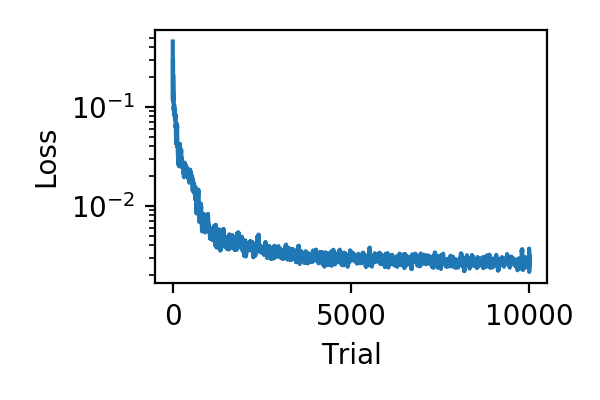

In [266]:
# Check that the agent learns when targets are randomly shuffled.

agent = Agent(sigma=0.03)
loss = agent.run_session(10000)

plt.figure(figsize=(3,2))
plt.semilogy(smooth(loss, 21))
plt.xlabel('Trial')
plt.ylabel('Loss')
plt.tight_layout()

<IPython.core.display.Javascript object>


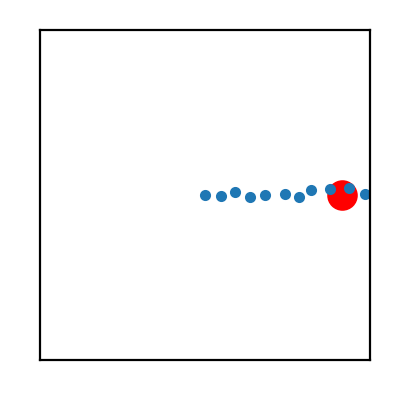

In [268]:
_ = agent.run_trial(0, plot_traj=True)

# Control: Shuffled targets

Train the network to go to a randomly chosen target on each trial.

In [299]:
n_targets = 4
n_reps = 21
n_episodes = 52000
targets = np.random.choice(range(n_targets), n_episodes)

loss_interleaved_train = np.zeros((n_reps, n_episodes))
loss_interleaved_test = np.zeros(n_reps)
for ii in range(n_reps):
    # Create and train the network:
    print('\nTraining network ', ii+1, '/', n_reps)
    agent = Agent(learning_rates=(1e-4,0), sigma=0.03)
    loss_interleaved_train[ii,:] = agent.run_session(n_episodes, targets)

    # Turn off learning and test the network:
    print('Testing network...')
    agent.eta_w = 0
    targets_test = np.random.choice(range(n_targets), 1000)
    loss_ = agent.run_session(1000, targets_test, noise_decay=None)
    loss_interleaved_test[ii] = np.mean(loss_)

    print('Loss: ', loss_interleaved_test[ii])



Training network  1 / 21
Testing network...
Loss:  0.002314761500727984

Training network  2 / 21
Testing network...
Loss:  0.0023763934914889182

Training network  3 / 21
Testing network...
Loss:  0.0024558039214070165

Training network  4 / 21
Testing network...
Loss:  0.0027404917239872055

Training network  5 / 21
Testing network...
Loss:  0.002408391603826039

Training network  6 / 21
Testing network...
Loss:  0.0021646525271519037

Training network  7 / 21
Testing network...
Loss:  0.0019291754497234254

Training network  8 / 21
Testing network...
Loss:  0.002108732493146689

Training network  9 / 21
Testing network...
Loss:  0.002195305000861283

Training network  10 / 21
Testing network...
Loss:  0.0018589805924273404

Training network  11 / 21
Testing network...
Loss:  0.002603026185297889

Training network  12 / 21
Testing network...
Loss:  0.0021830555147335255

Training network  13 / 21
Testing network...
Loss:  0.0022969588089503004

Training network  14 / 21
Testing netw

In [300]:
np.save('results/loss_interleaved_train.npy', loss_interleaved_train)
np.save('results/loss_interleaved_test.npy', loss_interleaved_test)

In [5]:
# Load previously saved data:
if False:
    loss_interleaved_train = np.load('results/loss_interleaved_train.npy')
    loss_interleaved_test = np.load('results/loss_interleaved_test.npy')

<IPython.core.display.Javascript object>


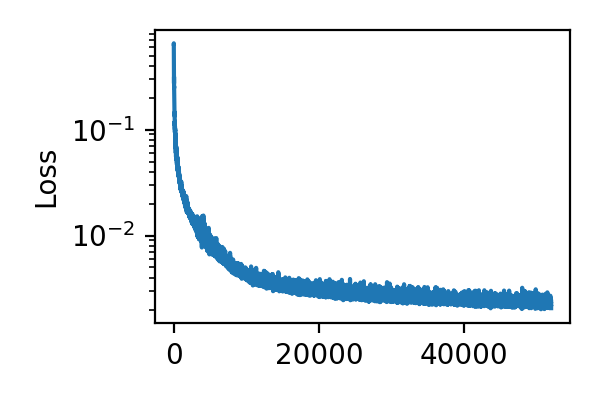

In [6]:
# Plot the training performance.

plt.figure(figsize=(3,2))
plt.semilogy(smooth(np.mean(loss_interleaved_train, axis=0), 5))
plt.ylabel('Loss')

plt.tight_layout()

# Sequential training without Hebbian learning

Next, train the network first to go to target 1 in a batch of trials, then to go to target 2 in the next batch, etc. Train on target 1 more than on other targets.

In [10]:
n_targets = 4
n_reps = 21
n_batches = 13
batch_size = 4000
n_episodes = n_batches*batch_size
targets = np.zeros(n_episodes, dtype=int)


In [302]:

for jj in range(n_batches-n_targets,n_batches):
    targets[jj*batch_size:(jj+1)*batch_size] = (jj-(n_batches-n_targets))*np.ones(batch_size)

loss_train = np.zeros((n_reps, n_episodes))
loss_test = np.zeros((n_reps, n_targets))

for ii in range(n_reps):
    print('\nTraining network ', ii+1, '/', n_reps)
    # Create and train a network:
    agent = Agent(learning_rates=(1e-3,0), sigma=0.03)
    loss_train[ii,:] = agent.run_session(n_episodes, targets, noise_decay=None)
    
    # Turn off learning and test the network on each target:
    print('Testing network...')
    agent.eta_w = 0
    for jj in range(n_targets):
        targets_test = jj*np.ones(1000, dtype=int)
        loss_ = agent.run_session(1000, targets_test, noise_decay=None)
        loss_test[ii,jj] = np.mean(loss_)

        print('(Target, Loss): ', (jj, loss_test[ii,jj]))



Training network  1 / 21
Testing network...
(Target, Loss):  (0, 0.08151249794962268)
(Target, Loss):  (1, 0.07265740245935302)
(Target, Loss):  (2, 0.08282262440744115)
(Target, Loss):  (3, 0.0018788460628681469)

Training network  2 / 21
Testing network...
(Target, Loss):  (0, 0.023422701754968616)
(Target, Loss):  (1, 0.01915333671056102)
(Target, Loss):  (2, 0.09517057261059451)
(Target, Loss):  (3, 0.0019472067237414174)

Training network  3 / 21
Testing network...
(Target, Loss):  (0, 0.0648597123723672)
(Target, Loss):  (1, 0.038042383616964985)
(Target, Loss):  (2, 0.03389149601700465)
(Target, Loss):  (3, 0.0019024874251590308)

Training network  4 / 21
Testing network...
(Target, Loss):  (0, 0.054861194838947955)
(Target, Loss):  (1, 0.01988793280094741)
(Target, Loss):  (2, 0.004599554260125311)
(Target, Loss):  (3, 0.0017050593671121264)

Training network  5 / 21
Testing network...
(Target, Loss):  (0, 0.4494052492912879)
(Target, Loss):  (1, 0.14966571969956755)
(Target, 

In [303]:
np.save('results/loss_train.npy', loss_train)
np.save('results/loss_test.npy', loss_test)

In [11]:
# Load previously saved data:
if False:
    loss_train = np.load('results/loss_train.npy')
    loss_test = np.load('results/loss_test.npy')

<IPython.core.display.Javascript object>


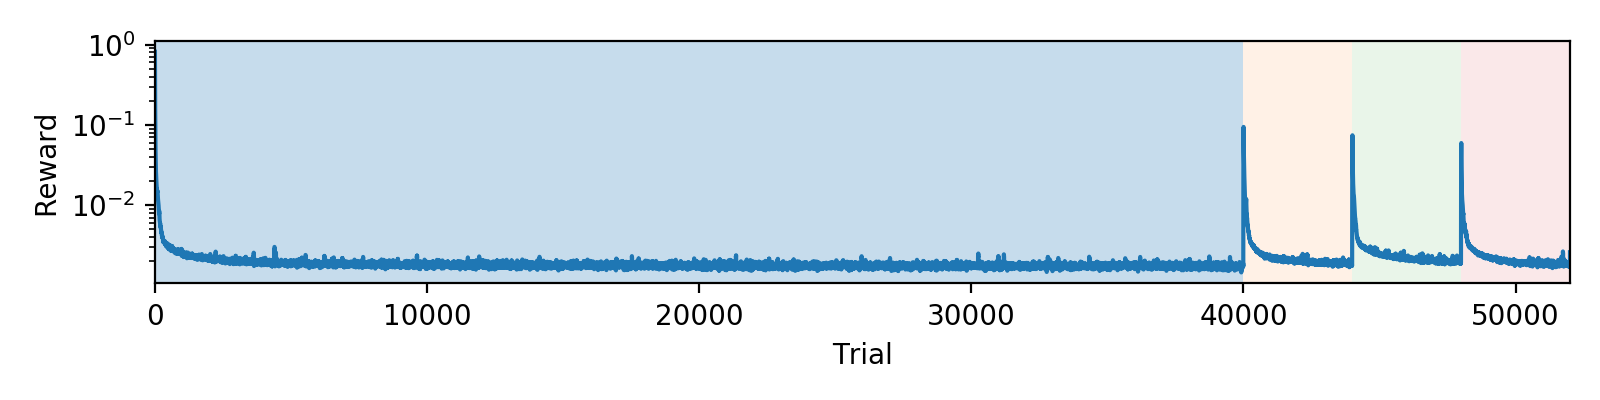

In [12]:
# Plot the training performance.

colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray')

plt.figure(figsize=(8,2))
plt.axvspan(0, (n_batches-n_targets+1)*batch_size, facecolor=colors[0], alpha=0.25)
for ii in range(n_batches-n_targets+1, n_batches):
    plt.axvspan(ii*batch_size, 
                (ii+1)*batch_size, 
                facecolor=colors[ii-(n_batches-n_targets)], alpha=0.1)
plt.semilogy(smooth(np.mean(loss_train, axis=0), 11))
plt.ylabel('Reward')
plt.xlabel('Trial')
plt.xlim(0, n_episodes)
#plt.xticks([0, 10e3, 11e3, 12e3, 13e3, 14e3, 15e3, 16e3, 17e3],
#           [0, '10k', '11k', '12k', '13k', '14k', '15k', '16k', '17k'])

plt.tight_layout()
plt.savefig('figs/train_sequence_hebbless.pdf')

# Sequential training with Hebbian learning

Do the same as above, but now with Hebbian learning turned on.

In [13]:
def trainHL(etaH, n_episodes, n_reps):
    targets = np.zeros(n_episodes, dtype=int)
    for jj in range(n_batches-n_targets,n_batches):
        targets[jj*batch_size:(jj+1)*batch_size] = (jj-(n_batches-n_targets))*np.ones(batch_size)

    lossH_train = np.zeros((n_reps, n_episodes))
    lossH_test = np.zeros((n_reps, n_targets))

    for ii in range(n_reps):
        print('\nTraining network ', ii+1, '/', n_reps)
        # Create and train a network:
        agent = Agent(learning_rates=(1e-4, etaH), sigma=0.03)
        #agent = Agent(learning_rates=(3e-5,etaH))
        lossH_train[ii,:] = agent.run_session(n_episodes, targets, noise_decay=None)

        # Turn off learning and test the network on each target:
        print('Testing network...')
        agent.eta_w = 0
        agent.eta_v = 0
        for jj in range(n_targets):
            targets_test = jj*np.ones(1000, dtype=int)
            loss_test = jj*np.ones(1000, dtype=int)
            loss_ = agent.run_session(1000, targets_test, noise_decay=None)
            lossH_test[ii,jj] = np.mean(loss_)

            print('(Target, Loss): ', (jj, lossH_test[ii,jj]))
    
    return lossH_train, lossH_test

In [14]:
# Hebbian learning rates to try:
etaH_list = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

In [306]:
n_reps = 21
batch_size = 4000
n_batches = 13
n_episodes = n_batches*batch_size
targets = np.zeros(n_episodes, dtype=int)

lossH_train = np.zeros((len(etaH_list), n_reps, n_episodes))
lossH_test = np.zeros((len(etaH_list), n_reps, n_targets))
for ii, etaH in enumerate(etaH_list):
    print('\netaH = ', etaH)
    lossH_train[ii,:], lossH_test[ii,:] = trainHL(etaH, n_episodes, n_reps)


etaH =  1e-08

Training network  1 / 21
Testing network...
(Target, Loss):  (0, 0.03528970230937243)
(Target, Loss):  (1, 0.0654676595779006)
(Target, Loss):  (2, 0.11960739475502635)
(Target, Loss):  (3, 0.0021406131930535484)

Training network  2 / 21
Testing network...
(Target, Loss):  (0, 0.02283285017535357)
(Target, Loss):  (1, 0.02662124998035329)
(Target, Loss):  (2, 0.005564592513808944)
(Target, Loss):  (3, 0.0035728144199224515)

Training network  3 / 21
Testing network...
(Target, Loss):  (0, 0.03462900372188818)
(Target, Loss):  (1, 0.013500561326308837)
(Target, Loss):  (2, 0.00858704614550567)
(Target, Loss):  (3, 0.0026427585924768005)

Training network  4 / 21
Testing network...
(Target, Loss):  (0, 0.013508774432705454)
(Target, Loss):  (1, 0.009715623049760353)
(Target, Loss):  (2, 0.008402043814143273)
(Target, Loss):  (3, 0.003504006662157909)

Training network  5 / 21
Testing network...
(Target, Loss):  (0, 0.14691532659595413)
(Target, Loss):  (1, 0.095969801652

(Target, Loss):  (3, 0.003933694200233248)

Training network  18 / 21
Testing network...
(Target, Loss):  (0, 0.02175263454577879)
(Target, Loss):  (1, 0.011271492581717045)
(Target, Loss):  (2, 0.01989960362309967)
(Target, Loss):  (3, 0.002652093900007649)

Training network  19 / 21
Testing network...
(Target, Loss):  (0, 0.05707299537437707)
(Target, Loss):  (1, 0.018218735146414228)
(Target, Loss):  (2, 0.00783964729713705)
(Target, Loss):  (3, 0.002395790515115782)

Training network  20 / 21
Testing network...
(Target, Loss):  (0, 0.017753669802000785)
(Target, Loss):  (1, 0.019229940308404664)
(Target, Loss):  (2, 0.003682032065731643)
(Target, Loss):  (3, 0.002484627879559489)

Training network  21 / 21
Testing network...
(Target, Loss):  (0, 0.013429954315565136)
(Target, Loss):  (1, 0.011622238197180456)
(Target, Loss):  (2, 0.011835543688783375)
(Target, Loss):  (3, 0.0028572179897027724)

etaH =  1e-06

Training network  1 / 21
Testing network...
(Target, Loss):  (0, 0.00602

(Target, Loss):  (2, 0.0059903599741014165)
(Target, Loss):  (3, 0.0030362907387119368)

Training network  14 / 21
Testing network...
(Target, Loss):  (0, 0.020084664628938494)
(Target, Loss):  (1, 0.013116763614446036)
(Target, Loss):  (2, 0.006056346794777459)
(Target, Loss):  (3, 0.003019300014300173)

Training network  15 / 21
Testing network...
(Target, Loss):  (0, 0.018648070800300898)
(Target, Loss):  (1, 0.01365115118263408)
(Target, Loss):  (2, 0.0213073384143027)
(Target, Loss):  (3, 0.004414436707284425)

Training network  16 / 21
Testing network...
(Target, Loss):  (0, 0.038141572779073894)
(Target, Loss):  (1, 0.016758586490650897)
(Target, Loss):  (2, 0.058538123328115275)
(Target, Loss):  (3, 0.0030195723147580437)

Training network  17 / 21
Testing network...
(Target, Loss):  (0, 0.1242193397370899)
(Target, Loss):  (1, 0.19881432251916323)
(Target, Loss):  (2, 0.07283406168881733)
(Target, Loss):  (3, 0.0030224984328122537)

Training network  18 / 21
Testing network...

In [307]:
np.save('results/lossH_train.npy', lossH_train)
np.save('results/lossH_test.npy', lossH_test)

In [15]:
# Load previously saved data:
if False:
    lossH_train = np.load('results/lossH_train.npy')
    lossH_test = np.load('results/lossH_test.npy')

In [16]:
# Testing performance:

for ii, eta in enumerate(etaH_list):
    print('etaH = ', eta)
    print('Loss at target (0,1,2,...): ')
    print(np.median(lossH_test[ii,:,:], axis=0))

etaH =  1e-08
Loss at target (0,1,2,...): 
[0.03183783 0.02207034 0.00865286 0.00336886]
etaH =  1e-07
Loss at target (0,1,2,...): 
[0.03887228 0.01935386 0.01183554 0.00281212]
etaH =  1e-06
Loss at target (0,1,2,...): 
[0.00744755 0.01368034 0.01669976 0.00310515]
etaH =  1e-05
Loss at target (0,1,2,...): 
[0.01352562 0.01319067 0.01295746 0.00303743]
etaH =  0.0001
Loss at target (0,1,2,...): 
[0.0200599  0.01305553 0.01985628 0.0030463 ]


In [17]:
# The best value of etaH:

etaH_best_index = 2

<IPython.core.display.Javascript object>


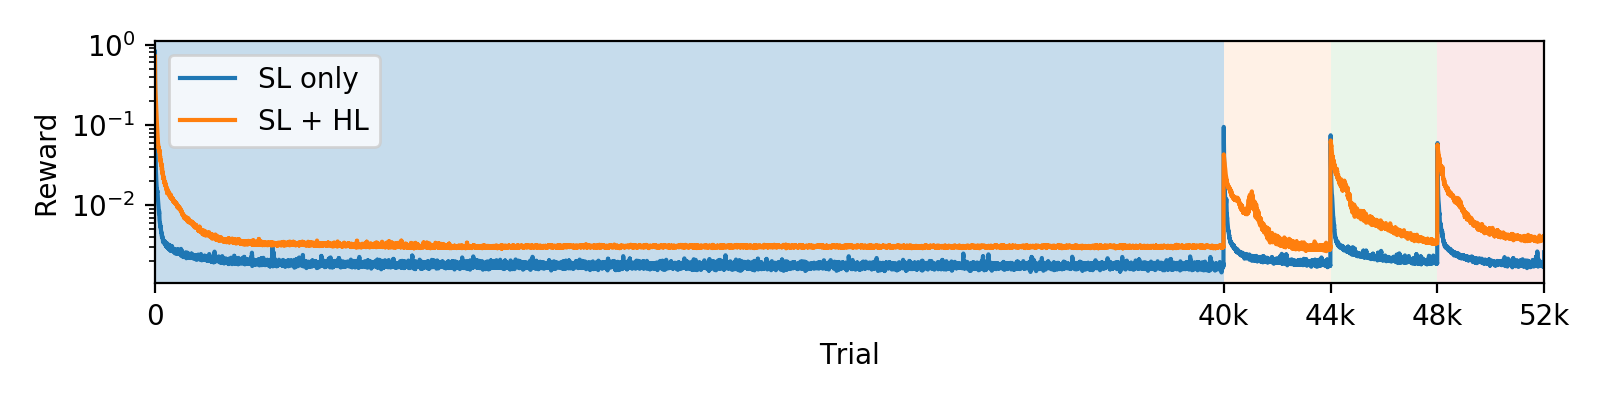

In [18]:
# Plot the training data from the cases with and without Hebbian learning together.

colors = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray')

plt.figure(figsize=(8,2))
plt.axvspan(0, (n_batches-n_targets+1)*batch_size, facecolor=colors[0], alpha=0.25)
for ii in range(n_batches-n_targets+1, n_batches):
    plt.axvspan(ii*batch_size, 
                (ii+1)*batch_size, 
                facecolor=colors[ii-(n_batches-n_targets)], alpha=0.1)
plt.semilogy(smooth(np.mean(loss_train, axis=0), 11))
plt.semilogy(smooth(np.mean(lossH_train[etaH_best_index,:,:], axis=0), 11))
plt.ylabel('Reward')
plt.xlabel('Trial')
plt.xlim(0, n_episodes)
plt.xticks([0, 40e3, 44e3, 48e3, 52e3],
           [0, '40k', '44k', '48k', '52k'])

plt.legend(['SL only', 'SL + HL'])

plt.tight_layout()
plt.savefig('figs/train_sequence.pdf')

# Testing results

Plot the testing performance together for all cases, using the best case with Hebbian learning.

<IPython.core.display.Javascript object>


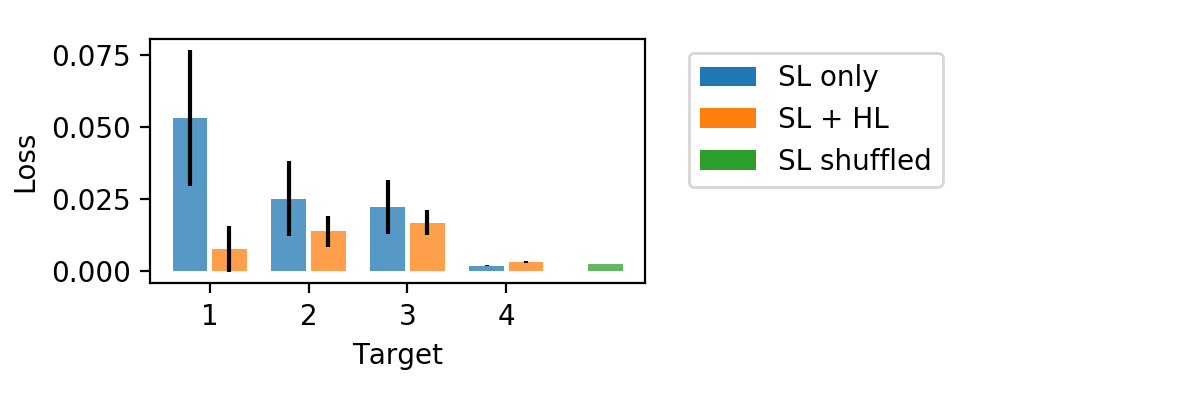

In [19]:
# Plot means and SEMs.

plt.figure(figsize=(6,2))

plt.subplot(121)
plt.bar(np.arange(1,n_targets+1)-0.2, np.median(loss_test, axis=0), width=0.35, 
        yerr=np.std(loss_test, axis=0)/n_reps**0.5, alpha=0.75)
plt.bar(np.arange(1,n_targets+1)+0.2, np.median(lossH_test[etaH_best_index,:,:], axis=0), width=0.35, 
        yerr=np.std(lossH_test[etaH_best_index,:,:], axis=0)/n_reps**0.5, alpha=0.75)
plt.bar([n_targets+1], np.median(loss_interleaved_test), width=0.35, 
        yerr=np.std(loss_interleaved_test)/n_reps**0.5, alpha=0.75)
plt.ylabel('Loss')
plt.xlabel('Target')
plt.xticks(1 + np.arange(n_targets))

plt.subplot(122)
plt.bar([0],[0])
plt.bar([0],[0])
plt.bar([0],[0])
plt.axis('off')
plt.legend(['SL only', 'SL + HL', 'SL shuffled'], loc='upper left')

plt.tight_layout()
plt.savefig('figs/train_sequence_testloss_std.pdf')

In [318]:
# Statistical significance:

from scipy import stats

t0, p0 = stats.ttest_ind(loss_test[:,0], lossH_test[etaH_best_index,:,0])
print('For first target with HL vs. without HL, p =', p0)

For first target with HL vs. without HL, p = 0.011049601986357306
